# 🧠 Notebook 2 — Modélisation & MLOps


Ce notebook débute après tout le travail d’EDA et de feature engineering réalisé dans le **Notebook 1**.


---


## 1. 📥 Chargement & Structuration des données (résultats du Notebook 1)


### Tables sources :
- `application_train` (table principale)
- `bureau`
- `bureau_balance`
- `previous_application`
- `installments_payments`
- `credit_card_balance`
- `POS_CASH_balance`


### Nettoyage initial effectué :
- Suppression des doublons  
- Harmonisation des types (dates, numériques, catégorielles)  
- Uniformisation des clés (`SK_ID_CURR`, `SK_ID_BUREAU`)  
- Sélection + renommage des colonnes pertinentes  


---


## 2. 📊 Agrégations réalisées (vision client consolidée)


### 2.1 Bureau :
- Nombre total de crédits externes  
- Crédits actifs / clôturés  
- Montants prêtés, restants, annuités  
- Durées contractuelles  
- Types de crédit  
- **Agrégations :** `mean`, `max`, `min`, `sum`, `std`


### 2.2 Bureau Balance :
- Historique mensuel des statuts  
- Durée d’activité des crédits externes  
- Variabilité des statuts  
- **Agrégations :** `mean`, `count`, `most_frequent`


### 2.3 Previous Application :
- Nombre de demandes antérieures  
- Statuts `Approved` / `Refused`  
- Montants (crédit, goods price, annuity)  
- Ratios financiers (CREDIT/GOODS, PAYMENT/CREDIT…)  
- Différences montants demandés / accordés  
- Durées prévues / réelles  
- Types de prêts  
- **Agrégations :** `mean`, `max`, `min`, `sum`, `std`, `count`


### 2.4 Installments Payments :
- Retards (`DPD`)  
- Paiements anticipés  
- Ratio `AMT_PAYMENT / AMT_INSTALMENT`  
- Totaux payés et dus  
- Nombre de retards  
- **Agrégations :** `mean`, `max`, `min`, `sum`, `std`


### 2.5 Credit Card Balance :
- Limite de crédit  
- Solde courant  
- Dépenses cumulées  
- Montants remboursés  
- Retards carte  
- **Agrégations :** `mean`, `max`, `min`, `sum`, `std`


### 2.6 POS_CASH Balance :
- Nombre d’échéances  
- Retards POS  
- Statuts de contrats  
- Cycles de paiement  
- **Agrégations :** `mean`, `max`, `min`, `sum`, `count`


---


## 3. 🧱 Consolidation finale


- Fusion de toutes les tables agrégées avec `application_train`  
- Construction d’un dataset final à **une ligne par client (`SK_ID_CURR`)**  
- Vision 360° du comportement financier  


---


## 4. 🧼 Propriétés du dataset final (`final_dataset.csv`)


Le dataset final est :
- propre et harmonisé  
- riche en information  
- agrégé à une ligne par client  
- stabilisé (moins de bruit via agrégations)  
- **sans fuite de données (no data leakage)**  
- prêt pour un pipeline ML  


---


## 5. 🎯 Objectifs du Notebook 2


- Charger le dataset final  
- Construire le pipeline de prétraitement :  
  - imputation  
  - encodage (OHE)  
  - scaling  
- Entraîner plusieurs modèles supervisés  
- Optimiser les hyperparamètres (`GridSearch`, `RandomizedSearch`)  
- Suivre les expériences via **MLflow**  
- Analyser l’importance globale & locale des features (**SHAP**)  
- Sélectionner + sauvegarder le meilleur modèle pour la mise en production  


---


# Notebook 02 – Modélisation & MLOps (Projet P7)


### 🎯 Objectif général
Construire, évaluer, expliquer et industrialiser un modèle de scoring permettant de prédire la probabilité de défaut d’un client.


### 🧱 Contenu du notebook
- Préparation et sélection de modèles supervisés
- Explicabilité globale et locale des prédictions
- Suivi et détection de dérive (data drift)
- Sauvegarde et pilotage MLOps (versioning du modèle)


### 🧩 Compétences évaluées (référentiel P7)
- CE2 — Analyser et préparer un modèle de Machine Learning
- CE3 — Appliquer des techniques d’évaluation (métriques, validation croisée, etc.)
- CE4 — Expliquer un modèle (SHAP / permutation importance)
- CE5 — Détecter un drift (dérive données / distribution)
- CE6 — Industrialiser le scoring (sauvegarde, API, monitoring)


### 📦 Contexte
L’objectif est d’anticiper la probabilité qu’un client entre en défaut de paiement.  
Nous séparons les données en train/test pour simuler un fonctionnement en production.


In [1]:

# === 📦 Imports & configuration ===
import os, json
from pathlib import Path
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
import mlflow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Essayez LightGBM/XGBoost si dispo
try:
    from xgboost import XGBClassifier    
    HAS_XGB = True
except Exception:
    HAS_XGB = False


# MLflow (désactivable si non installé)
USE_MLFLOW = True
try:
    import mlflow
    mlflow.set_experiment("p7_scoring")
except Exception:
    USE_MLFLOW = False
    print("⚠️ MLflow non disponible — le tracking sera ignoré.")


c:\Users\S46652\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\tracking\_tracking_service\utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)


In [2]:
# 📂 Chargement du fichier issu du Notebook 1
DATA_DIR = Path("Data")
RAW_FILE = DATA_DIR / "app_train.csv"


# 🔎 Lecture du CSV
df = pd.read_csv(RAW_FILE)


# ✅ Vérification rapide de la structure
print(f"✅ Dataset chargé avec succès : {df.shape[0]:,} lignes × {df.shape[1]:,} colonnes")


# 🧩 Aperçu des premières lignes
display(df.head(5))


# 🎯 Vérification de la présence de la cible
assert "TARGET" in df.columns, "❌ Colonne cible 'TARGET' manquante dans le dataset."
print(f"✅ Colonne cible détectée — distribution :")
print(df["TARGET"].value_counts(normalize=True).map("{:.2%}".format))





✅ Dataset chargé avec succès : 307,511 lignes × 241 colonnes


,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET,DAYS_EMPLOYED_ANOM
0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,False,False,False,False,True,False,True,False,1,False
1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,False,False,False,False,False,False,True,False,0,False
2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,False,False,False,False,False,False,False,False,0,False
3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,False,False,False,False,False,False,False,False,0,False
4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,False,False,False,False,False,False,False,False,0,False


✅ Colonne cible détectée — distribution :
TARGET
0    91.93%
1     8.07%
Name: proportion, dtype: object



## 1) Chargement & préparation basique
- Sélection des features et de la cible
- Split train/test **stratifié**


In [3]:
print(f"✅ Dataset chargé : {df.shape[0]:,} lignes × {df.shape[1]:,} colonnes")
display(df.head(3))


# === ⚙️ Préparation X / y ===
TARGET_COL = "TARGET"
ID_COL = "SK_ID_CURR"  # adapte si nécessaire


# Vérifications
assert TARGET_COL in df.columns, "❌ Colonne cible manquante."
assert ID_COL in df.columns, "❌ Identifiant manquant."


y = df[TARGET_COL].astype(int)
X = df.drop(columns=[TARGET_COL, ID_COL], errors="ignore")


# Détection automatique des types
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()


print(f"\n📈 Variables numériques : {len(num_cols)} | 🔤 Catégorielles : {len(cat_cols)}")


# === 🧪 Split Train / Test ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


print(f"\n✅ Split terminé : {X_train.shape} train / {X_test.shape} test")
print(f"📉 Part cible positive (train) : {y_train.mean():.3f}")


✅ Dataset chargé : 307,511 lignes × 241 colonnes


,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET,DAYS_EMPLOYED_ANOM
0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,False,False,False,False,True,False,True,False,1,False
1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,False,False,False,False,False,False,True,False,0,False
2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,False,False,False,False,False,False,False,False,0,False



📈 Variables numériques : 107 | 🔤 Catégorielles : 132

✅ Split terminé : (246008, 239) train / (61503, 239) test
📉 Part cible positive (train) : 0.081



## 2) Pipeline de prétraitement + modèle
- Imputation, encodage One-Hot, standardisation (pour LR).
- Modèles testés : **Régression Logistique** (baseline) et **XGBoost** (si dispo).


In [4]:
# === ⚙️ Prétraitement adapté pour Notebook 2 ===
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# Toute la donnée est déjà numérique -> pas de colonnes catégorielles
all_numeric_cols = X_train.columns.tolist()


# Pipeline numérique : imputation + standardisation
numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])


# ColumnTransformer appliqué à toutes les colonnes
preprocess = ColumnTransformer([
    ("num", numeric_pipe, all_numeric_cols)
])


print("✅ Préprocessing Notebook 2 chargé (imputation + scaling)")


✅ Préprocessing Notebook 2 chargé (imputation + scaling)


## Régression Logistique

In [5]:
# === 🧮 Modèle 1 : Régression Logistique (baseline explicable) ===
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    n_jobs=None
)


pipe_lr = Pipeline([
    ("prep", preprocess),
    ("clf", log_reg)
])


print("✅ Pipeline de régression logistique initialisé.")


✅ Pipeline de régression logistique initialisé.


In [6]:
from sklearn.model_selection import GridSearchCV


param_grid_lr = {
    "clf__C": [0.01, 0.1, 1, 10],
}


grid_lr = GridSearchCV(
    estimator=pipe_lr.set_params(
        clf__penalty="l2",
        clf__solver="lbfgs",
        clf__class_weight="balanced",
        clf__max_iter=1000
    ),
    param_grid=param_grid_lr,
    scoring="roc_auc",
    cv=3,          # 🔥 suffisant pour une baseline
    n_jobs=-1,     # 🔥 parallélisation
    verbose=2
)


print("🔎 Grid Search — Régression Logistique (baseline)")
grid_lr.fit(X_train, y_train)


best_lr_model = grid_lr.best_estimator_


print("🎯 Best params :", grid_lr.best_params_)
print("🏆 Best ROC-AUC CV :", grid_lr.best_score_)


🔎 Grid Search — Régression Logistique (baseline)
Fitting 3 folds for each of 4 candidates, totalling 12 fits
🎯 Best params : {'clf__C': 0.01}
🏆 Best ROC-AUC CV : 0.7443195965132858


In [7]:
from sklearn.metrics import roc_auc_score


y_pred_lr = best_lr_model.predict_proba(X_test)[:, 1]
roc_auc_lr = roc_auc_score(y_test, y_pred_lr)


print(f"🎯 ROC-AUC (LR optimisée) : {roc_auc_lr:.4f}")


🎯 ROC-AUC (LR optimisée) : 0.7490


## ===  XGBoost  ===

In [8]:
# === ⚡ Modèle 2 : XGBoost (si disponible) ===
if HAS_XGB:
    xgb = XGBClassifier(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=42
    )


    pipe_xgb = Pipeline([
        ("prep", preprocess),
        ("clf", xgb)
    ])
    print("✅ Pipeline XGBoost initialisé.")
else:
    print("⚠️ XGBoost non disponible sur cet environnement.")


✅ Pipeline XGBoost initialisé.


In [9]:
from sklearn.model_selection import RandomizedSearchCV


# 1️⃣ On fixe la balance UNE FOIS
scale_pos = (y == 0).sum() / (y == 1).sum()

pipe_xgb.set_params(
    clf__scale_pos_weight=scale_pos
)


# 2️⃣ Distribution des hyperparamètres
param_dist_xgb = {
    "clf__n_estimators": [200, 400, 600],
    "clf__learning_rate": [0.01, 0.03, 0.05, 0.1],
    "clf__max_depth": [3, 5, 7],
    "clf__subsample": [0.7, 0.8, 0.9, 1.0],
    "clf__colsample_bytree": [0.7, 0.8, 1.0],
    "clf__reg_lambda": [0.5, 1.0, 2.0],
}


search_xgb = RandomizedSearchCV(
    estimator=pipe_xgb,
    param_distributions=param_dist_xgb,
    n_iter=25,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)


print("🔎 Lancement du RandomizedSearch XGBoost…")
search_xgb.fit(X_train, y_train)


best_xgb_model = search_xgb.best_estimator_


print("🎯 Best params XGB :", search_xgb.best_params_)
print("🏆 Best ROC-AUC CV :", search_xgb.best_score_)


🔎 Lancement du RandomizedSearch XGBoost…
Fitting 3 folds for each of 25 candidates, totalling 75 fits
🎯 Best params XGB : {'clf__subsample': 0.9, 'clf__reg_lambda': 2.0, 'clf__n_estimators': 400, 'clf__max_depth': 3, 'clf__learning_rate': 0.1, 'clf__colsample_bytree': 0.7}
🏆 Best ROC-AUC CV : 0.7556882979483287


In [10]:
if HAS_XGB:
    y_pred_xgb = best_xgb_model.predict_proba(X_test)[:, 1]
    roc_xgb = roc_auc_score(y_test, y_pred_xgb)
    print(f"🔥 ROC-AUC (XGBoost optimisé) : {roc_xgb:.4f}")


🔥 ROC-AUC (XGBoost optimisé) : 0.7618


## ===  lightgbm  ===

In [11]:
from lightgbm import LGBMClassifier


# ratio positif/négatif
scale_pos = (y == 0).sum() / (y == 1).sum()


lgbm_model = Pipeline([
    ("preprocess", preprocess),
    ("clf", LGBMClassifier(
        objective="binary",
        class_weight=None,           # on préfère scale_pos_weight pour stabilité
        scale_pos_weight=scale_pos,  # déséquilibre classes
        n_estimators=500,
        learning_rate=0.03,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=1
    ))
])


In [12]:
# ============================================================
# 🔍 Grid Search — LightGBM
# ============================================================


from sklearn.model_selection import GridSearchCV


from sklearn.model_selection import RandomizedSearchCV


param_dist_lgbm = {
    "clf__n_estimators": [200, 400, 600],
    "clf__learning_rate": [0.01, 0.03, 0.05, 0.1],
    "clf__num_leaves": [31, 63, 127],
    "clf__subsample": [0.8, 1.0],
    "clf__colsample_bytree": [0.7, 0.8, 1.0],
    "clf__scale_pos_weight": [scale_pos],
}


search_lgbm = RandomizedSearchCV(
    estimator=lgbm_model,
    param_distributions=param_dist_lgbm,
    n_iter=25,                 # 🔥 25 essais intelligents
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,                 # ⚠️ LightGBM supporte le parallélisme
    verbose=2,
    random_state=42
)


print("🔎 Lancement du RandomizedSearch LightGBM…")
search_lgbm.fit(X_train, y_train)


best_lgbm_model = search_lgbm.best_estimator_


print("🎯 Best params :", search_lgbm.best_params_)
print("🏆 Best ROC-AUC CV :", search_lgbm.best_score_)


🔎 Lancement du RandomizedSearch LightGBM…
Fitting 3 folds for each of 25 candidates, totalling 75 fits
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.210119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11424
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 231
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
🎯 Best params : {'clf__subsample': 1.0, 'clf__scale_pos_weight': 11.387150050352467, 'clf__num_leaves': 63, 'clf__n_estimators': 600, 'clf__learning_rate': 0.01, 'clf__colsample_bytree': 0.7}
🏆 Best ROC-AUC CV : 0.7552838247787163


In [13]:
y_pred_lgbm = best_lgbm_model.predict_proba(X_test)[:, 1]
roc_lgbm = roc_auc_score(y_test, y_pred_lgbm)


print(f"🔥 ROC-AUC (LightGBM optimisé) : {roc_lgbm:.4f}")


c:\Users\S46652\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


🔥 ROC-AUC (LightGBM optimisé) : 0.7608


## ===  GradientBoosting  ===

In [14]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline


gb_model = Pipeline([
    ("preprocess", preprocess),
    ("clf", GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        max_depth=3,
        subsample=0.8,
        random_state=42
    ))
])


In [15]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold




# ----------------------------------------
# ⚖️ Gestion du déséquilibre 90 / 10
# ----------------------------------------
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()




# ----------------------------------------
# 🌳 Modèle XGBoost
# ----------------------------------------
xgb = XGBClassifier(
    objective="binary:logistic",
    scale_pos_weight=scale_pos_weight,
    eval_metric="auc",
    n_jobs=-1,
    random_state=42,
    tree_method="hist"
)




# ----------------------------------------
# 🔍 Espace de recherche
# ----------------------------------------
param_dist = {
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7],
    "n_estimators": [200, 400, 600],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}




# ----------------------------------------
# 🔁 Cross-validation stratifiée
# ----------------------------------------
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)




# ----------------------------------------
# 🎯 Randomized Search
# ----------------------------------------
search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20,
    scoring="roc_auc",
    cv=cv,
    verbose=2,
    n_jobs=-1,
    random_state=42
)




# ----------------------------------------
# 🚀 Entraînement
# ----------------------------------------
print("🔎 Lancement du RandomizedSearch XGBoost…")
search.fit(X_train, y_train)




# ----------------------------------------
# 🏆 SORTIE : Best GB Model
# ----------------------------------------
best_gb_model = search.best_estimator_


print("\n🏆 BEST GB MODEL (XGBoost)")
print(best_gb_model)


print("\n🎯 Best params :", search.best_params_)
print("🏆 Best ROC-AUC CV :", search.best_score_)


🔎 Lancement du RandomizedSearch XGBoost…
Fitting 3 folds for each of 20 candidates, totalling 60 fits

🏆 BEST GB MODEL (XGBoost)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=600, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

🎯 Best params : {'subsample': 0.8, 'n_estimators': 600, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 1.0}


In [16]:
y_pred_gb = best_gb_model.predict_proba(X_test)[:, 1]
roc_gb = roc_auc_score(y_test, y_pred_gb)


print(f"🔥 ROC-AUC (Gradient Boosting optimisé) : {roc_gb:.4f}")


🔥 ROC-AUC (Gradient Boosting optimisé) : 0.7618


# Test du preprocess seul

In [17]:
# Test du preprocess seul
try:
    X_transformed = preprocess.fit_transform(X_train)
    print("✅ Préprocessing OK :", X_transformed.shape)
except Exception as e:
    print("❌ Erreur pendant le prétraitement :", e)


✅ Préprocessing OK : (246008, 239)


In [18]:
# === 💰 Score métier : optimisation du seuil ===


import numpy as np
from sklearn.metrics import confusion_matrix


# Coûts métier définis dans l'énoncé
FN_COST = 10   # Mauvais client accepté
FP_COST = 1    # Bon client refusé


def business_cost_with_best_threshold(y_true, y_proba):
    """
    Calcule le coût métier minimal en testant différents seuils.
    Retourne :
        - best_cost : coût minimal
        - best_threshold : seuil optimal
        - best_cm : matrice de confusion associée
    """
    
    thresholds = np.linspace(0.01, 0.99, 99)


    best_cost = np.inf
    best_threshold = None
    best_cm = None


    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)


        # Erreurs métier
        fn = np.sum((y_true == 1) & (y_pred == 0))  # mauvais client accepté
        fp = np.sum((y_true == 0) & (y_pred == 1))  # bon client refusé


        # Coût métier
        cost = fn * FN_COST + fp * FP_COST


        # On garde le meilleur
        if cost < best_cost:
            best_cost = cost
            best_threshold = t
            best_cm = confusion_matrix(y_true, y_pred)


    return best_cost, best_threshold, best_cm



## 3) Entraînement, évaluation & tracking MLflow
- Métriques clés : **ROC-AUC** (global), **F1** (avec class_weight) et **rapport de classification**.
- Journalisation des paramètres & métriques.


In [69]:
def fit_eval_model(name, pipe):
    """
    Entraîne un pipeline ML, calcule les métriques,
    et loggue l'ensemble des éléments nécessaires dans MLflow
    conformément au référentiel OpenClassrooms.
    """


    # =======================================================
    # 🔥 0 — Imports internes
    # =======================================================
    import os
    import sys
    import mlflow
    import mlflow.sklearn
    import matplotlib.pyplot as plt


    from sklearn.metrics import (
        roc_auc_score,
        f1_score,
        roc_curve,
        confusion_matrix,
        classification_report
    )


    # =======================================================
    # 📁 Dossier artefacts
    # =======================================================
    os.makedirs("artefacts", exist_ok=True)


    # =======================================================
    # ⚙️ 1 — Démarrage du run MLflow (RUN ENFANT)
    # =======================================================
    if USE_MLFLOW:
        mlflow.start_run(run_name=name, nested=True)


        # Tags lisibles en soutenance
        mlflow.set_tag("model_name", name)
        mlflow.set_tag("project", "OC_Credit_Scoring")
        mlflow.set_tag("estimator", pipe.__class__.__name__)


        # 🔥 OBLIGATOIRE OC : hyperparamètres
        mlflow.log_params(pipe.get_params())


    # =======================================================
    # 🧠 2 — Entraînement
    # =======================================================
    pipe.fit(X_train, y_train)


    # =======================================================
    # 🔍 3 — Prédictions
    # =======================================================
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]


    # Métriques principales
    auc = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)


    # -------------------------------------------------------
    # 💰 Score métier + seuil optimal
    # -------------------------------------------------------
    business_cost, best_threshold, cm = business_cost_with_best_threshold(
        y_test, y_proba
    )


    # =======================================================
    # 📊 4 — Plots
    # =======================================================
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve — {name}")
    plt.legend()


    roc_path = f"artefacts/roc_{name}.png"
    plt.savefig(roc_path)
    plt.close()


    # Confusion Matrix
    plt.figure(figsize=(5, 4))
    plt.imshow(cm, cmap="Blues")
    plt.title(f"Confusion Matrix — {name}")
    plt.colorbar()
    plt.xlabel("Predicted")
    plt.ylabel("True")


    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center")


    cm_path = f"artefacts/cm_{name}.png"
    plt.savefig(cm_path)
    plt.close()


    # =======================================================
    # 📦 5 — Logging MLflow
    # =======================================================
    if USE_MLFLOW:
        # Métriques
        mlflow.log_metric("auc", auc)
        mlflow.log_metric("f1", f1)
        mlflow.log_metric("business_cost", business_cost)
        mlflow.log_metric("best_threshold", best_threshold)


        # Artefacts
        mlflow.log_artifact(roc_path, artifact_path="plots")
        mlflow.log_artifact(cm_path, artifact_path="plots")


        # Rapport texte (bonus OC)
        report = classification_report(y_test, y_pred)
        mlflow.log_text(report, "classification_report.txt")


        # Modèle (Model Registry)
        mlflow.sklearn.log_model(
            sk_model=pipe,
            artifact_path="model",
            registered_model_name=name
        )


        # Environnement conda (reproductibilité)
        conda_env = {
            "name": f"{name}_env",
            "channels": ["defaults", "conda-forge"],
            "dependencies": [
                f"python={'.'.join(map(str, sys.version_info[:3]))}",
                "scikit-learn",
                "pandas",
                "numpy",
                "mlflow",
                "matplotlib"
            ]
        }


        import yaml
        with open("artefacts/conda.yaml", "w") as f:
            yaml.dump(conda_env, f)


        mlflow.log_artifact("artefacts/conda.yaml")


        # Fin du run enfant
        mlflow.end_run()


    # =======================================================
    # 🔁 6 — Retour résultats
    # =======================================================
    return pipe, {
        "auc": auc,
        "f1": f1,
        "business_cost": business_cost,
        "best_threshold": best_threshold,
        "cm": cm
    }


In [70]:
# === 🚀 Entraînement & évaluation ===
results = {}
pipe_lr, results["log_reg"] = fit_eval_model("log_reg", pipe_lr)

if HAS_XGB:
    pipe_xgb, results["xgb"] = fit_eval_model("xgb", pipe_xgb)

lgbm_model, results["lgbm_model"] = fit_eval_model("lgbm_model", lgbm_model)

gb_model, results["gb_model"] = fit_eval_model("gb_model", gb_model)


print("\n📊 Résumé des performances :")
display(pd.DataFrame(results).T)


2025/12/19 15:47:34 WARNING mlflow.utils.validation: Param value '[('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', S...' (6850 characters) is truncated to 6000 characters to meet the length limit.
2025/12/19 15:47:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/19 15:48:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'log_reg' already exists. Creating a new version of this model...
Created version '4' of model 'log_reg'.
2025/12/19 15:48:02 WARNING mlflow.utils.validation: Param value '[('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', S...' (6850 characters) is truncated to 6000 characters to meet the length limit.
2025/12/19 15:48:34 WARNING mlflow.models.model: `artifact_path` is deprecated. 

[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.215857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11424
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 231
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482


c:\Users\S46652\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\S46652\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
2025/12/19 15:49:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/19 15:49:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'lgbm_model' already exists. Creating a new version of this model...
Created version '3' of model 'lgbm_model'.
2025/12/19 15:49:25 WARNING mlflow.utils.validation: Param value '[('num', Pipeline(steps=[('imputer', SimpleImputer(str


📊 Résumé des performances :


,auc,f1,business_cost,best_threshold,cm
log_reg,0.748872,0.260041,33250,0.534646,"[[41828, 14710], [1854, 3111]]"
xgb,0.760156,0.275017,32279,0.504949,"[[41029, 15509], [1677, 3288]]"
lgbm_model,0.761191,0.273358,32157,0.514848,"[[41331, 15207], [1695, 3270]]"
gb_model,0.757187,0.033991,32520,0.089192,"[[42148, 14390], [1813, 3152]]"


In [71]:
# =====================================================
# 🏆 Sélection du modèle final (choix projet)
# =====================================================


best_model_name = min(
    results,
    key=lambda m: results[m]["business_cost"]
)


print(f"✅ Modèle retenu : {best_model_name}")


✅ Modèle retenu : lgbm_model


In [72]:
from mlflow.tracking import MlflowClient


client = MlflowClient()


client.transition_model_version_stage(
    name=best_model_name,
    version=1,
    stage="Production",
    archive_existing_versions=True
)


C:\Users\S46652\AppData\Local\Temp\ipykernel_13756\2028582991.py:7: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


<ModelVersion: aliases=[], creation_timestamp=1765822767334, current_stage='Production', deployment_job_state=None, description=None, last_updated_timestamp=1766156639278, metrics=[<Metric: dataset_digest=None, dataset_name=None, key='auc', model_id='m-50917bcbf64645a285dadff944af6e45', run_id='4e12e19178d84e92a52ce9183c05f1b9', step=0, timestamp=1765822755745, value=0.7611914552598672>,
 <Metric: dataset_digest=None, dataset_name=None, key='best_threshold', model_id='m-50917bcbf64645a285dadff944af6e45', run_id='4e12e19178d84e92a52ce9183c05f1b9', step=0, timestamp=1765822755774, value=0.53>,
 <Metric: dataset_digest=None, dataset_name=None, key='business_cost', model_id='m-50917bcbf64645a285dadff944af6e45', run_id='4e12e19178d84e92a52ce9183c05f1b9', step=0, timestamp=1765822755767, value=32149.0>,
 <Metric: dataset_digest=None, dataset_name=None, key='f1', model_id='m-50917bcbf64645a285dadff944af6e45', run_id='4e12e19178d84e92a52ce9183c05f1b9', step=0, timestamp=1765822755756, value=0.


## 4) Courbe ROC & matrice de confusion


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    f1_score
)


def plot_roc_curve(y_true, y_proba, model_name):
    auc = roc_auc_score(y_true, y_proba)
    fpr, tpr, _ = roc_curve(y_true, y_proba)


    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="grey")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve — {model_name}")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


def plot_confusion_matrix(y_true, y_proba, threshold, model_name):
    y_pred = (y_proba >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)


    plt.figure(figsize=(5, 4))
    plt.imshow(cm, cmap="Blues")
    plt.title(f"Confusion Matrix — {model_name}")
    plt.colorbar()
    plt.xlabel("Predicted")
    plt.ylabel("True")


    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center")


    plt.tight_layout()
    plt.show()


    return cm


In [23]:
def business_cost_with_best_threshold(
    y_true,
    y_proba,
    cost_fp=1,
    cost_fn=10
):
    thresholds = np.linspace(0.01, 0.99, 100)
    best_cost = np.inf
    best_threshold = 0.5
    best_cm = None


    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        cm = confusion_matrix(y_true, y_pred)


        tn, fp, fn, tp = cm.ravel()
        cost = cost_fp * fp + cost_fn * fn


        if cost < best_cost:
            best_cost = cost
            best_threshold = t
            best_cm = cm


    return best_cost, best_threshold, best_cm


In [24]:
def fit_eval_model(name, pipe):
    # ============================
    # Entraînement
    # ============================
    pipe.fit(X_train, y_train)


    # ============================
    # Prédictions
    # ============================
    y_proba = pipe.predict_proba(X_test)[:, 1]
    y_pred = pipe.predict(X_test)


    # ============================
    # Métriques
    # ============================
    auc = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)


    business_cost, best_threshold, cm = business_cost_with_best_threshold(
        y_test,
        y_proba
    )


    # ============================
    # Visualisations
    # ============================
    plot_roc_curve(y_test, y_proba, name)
    plot_confusion_matrix(
        y_test,
        y_proba,
        threshold=best_threshold,
        model_name=name
    )


    # ============================
    # Console
    # ============================
    print(f"\n[{name}] ===============================")
    print(f"AUC                 : {auc:.4f}")
    print(f"F1-score            : {f1:.4f}")
    print(f"Coût métier minimal : {business_cost:.2f}")
    print(f"Seuil optimal       : {best_threshold:.3f}")
    print("Matrice de confusion :\n", cm)


    return pipe, {
        "auc": auc,
        "f1": f1,
        "business_cost": business_cost,
        "best_threshold": best_threshold,
        "cm": cm
    }


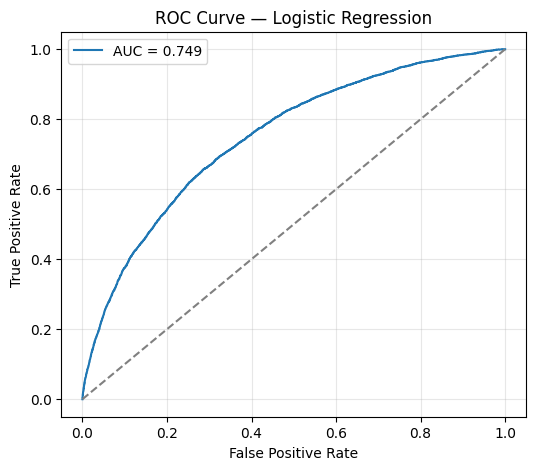

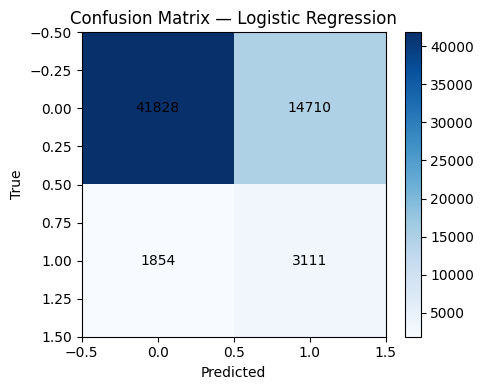


[Logistic Regression] ===============================
AUC                 : 0.7489
F1-score            : 0.2600
Coût métier minimal : 33250.00
Seuil optimal       : 0.535
Matrice de confusion :
 [[41828 14710]
 [ 1854  3111]]


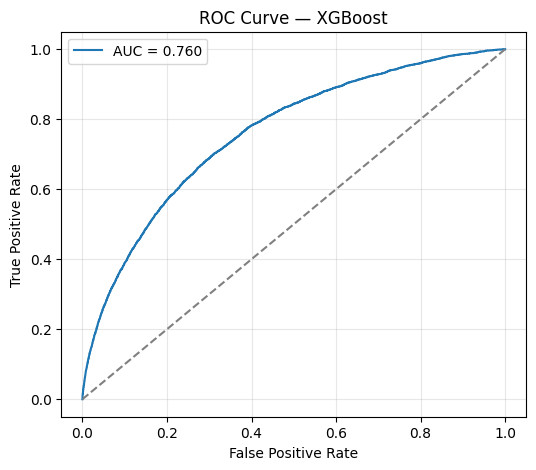

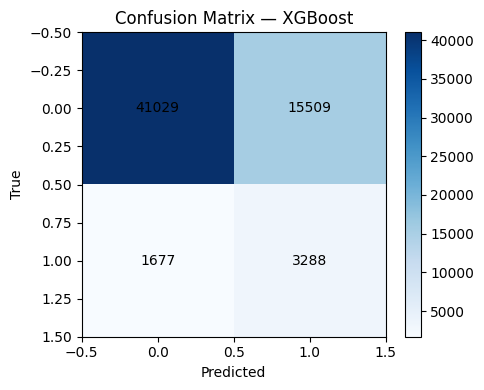


[XGBoost] ===============================
AUC                 : 0.7602
F1-score            : 0.2750
Coût métier minimal : 32279.00
Seuil optimal       : 0.505
Matrice de confusion :
 [[41029 15509]
 [ 1677  3288]]
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.220285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11424
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 231
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482


c:\Users\S46652\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\S46652\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


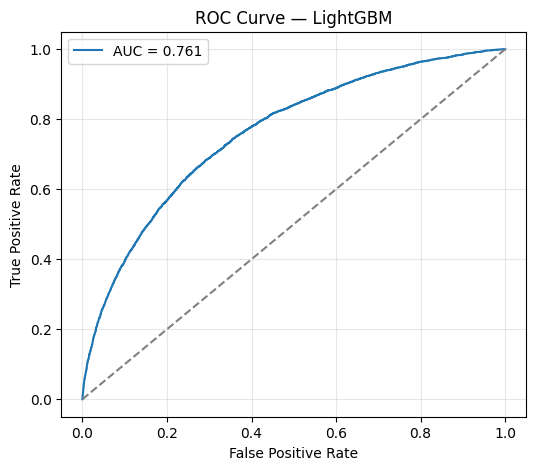

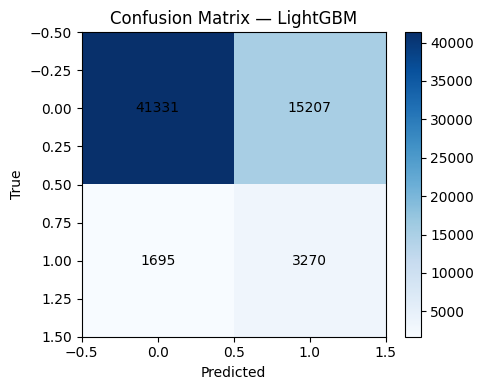


[LightGBM] ===============================
AUC                 : 0.7612
F1-score            : 0.2734
Coût métier minimal : 32157.00
Seuil optimal       : 0.515
Matrice de confusion :
 [[41331 15207]
 [ 1695  3270]]


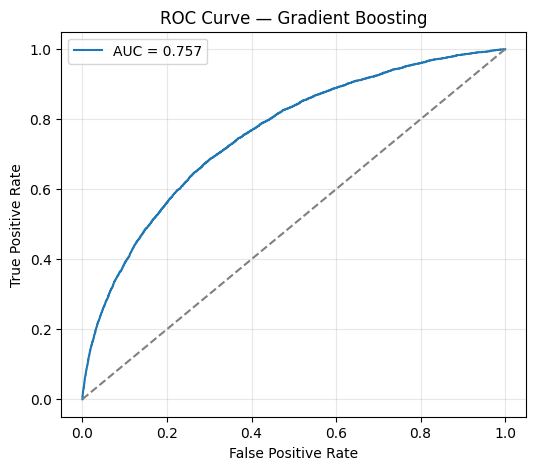

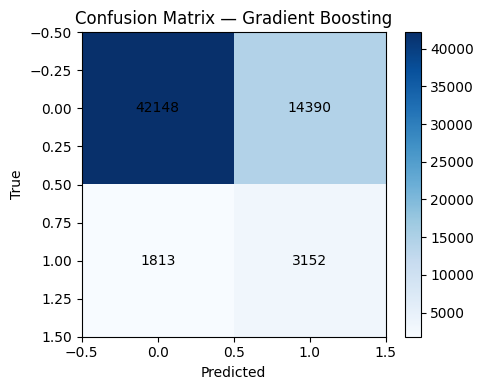


[Gradient Boosting] ===============================
AUC                 : 0.7572
F1-score            : 0.0340
Coût métier minimal : 32520.00
Seuil optimal       : 0.089
Matrice de confusion :
 [[42148 14390]
 [ 1813  3152]]


,auc,f1,business_cost,best_threshold,cm
log_reg,0.748872,0.260041,33250,0.534646,"[[41828, 14710], [1854, 3111]]"
xgb,0.760156,0.275017,32279,0.504949,"[[41029, 15509], [1677, 3288]]"
lgbm,0.761191,0.273358,32157,0.514848,"[[41331, 15207], [1695, 3270]]"
gb,0.757187,0.033991,32520,0.089192,"[[42148, 14390], [1813, 3152]]"


In [26]:
results = {}


pipe_lr, results["log_reg"] = fit_eval_model("Logistic Regression", pipe_lr)


if HAS_XGB:
    pipe_xgb, results["xgb"] = fit_eval_model("XGBoost", pipe_xgb)


lgbm_model, results["lgbm"] = fit_eval_model("LightGBM", lgbm_model)


gb_model, results["gb"] = fit_eval_model("Gradient Boosting", gb_model)


# ============================
# Résumé final
# ============================
display(pd.DataFrame(results).T)


In [28]:
# ============================
# 🏆 Sélection du meilleur modèle
# ============================


results_df = pd.DataFrame(results).T


best_model_name = results_df["business_cost"].idxmin()
print(f"🏆 Best model selected: {best_model_name}")


# Mapping nom -> pipeline
pipes = {
    "log_reg": pipe_lr,
    "xgb": pipe_xgb if HAS_XGB else None,
    "lgbm": lgbm_model,
    "gb": gb_model
}


best_pipe = pipes[best_model_name]


🏆 Best model selected: lgbm


# Sélection & importance des variables

,feature,importance
0,num__EXT_SOURCE_1,826
1,num__AMT_CREDIT,819
2,num__EXT_SOURCE_3,797
3,num__DAYS_BIRTH,762
4,num__EXT_SOURCE_2,755
5,num__AMT_ANNUITY,720
6,num__DAYS_EMPLOYED,658
7,num__AMT_GOODS_PRICE,584
8,num__DAYS_ID_PUBLISH,540
9,num__DAYS_LAST_PHONE_CHANGE,472


<Figure size 1800x1000 with 0 Axes>

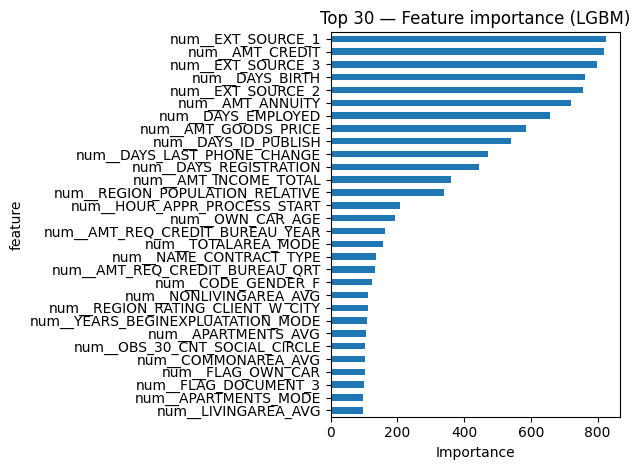

✔️ Feature importances exportées → reports/feature_importances_lgbm.csv


In [36]:
# =====================================================
# 📦 CE2 — Feature importance (ROBUSTE & CORRECT)
# =====================================================


import pandas as pd
import matplotlib.pyplot as plt
import os


PIPE = best_pipe
MODEL_NAME = best_model_name.upper()
TOP_N = 30
EXPORT_DIR = "reports"


os.makedirs(EXPORT_DIR, exist_ok=True)


# -----------------------------------------------------
# 1) Classifieur
# -----------------------------------------------------
clf = PIPE.named_steps["clf"]


# -----------------------------------------------------
# 2) Importances
# -----------------------------------------------------
if hasattr(clf, "feature_importances_"):
    importances = clf.feature_importances_
elif hasattr(clf, "coef_"):
    importances = abs(clf.coef_).ravel()
else:
    raise ValueError("❌ Modèle non compatible")


# -----------------------------------------------------
# 3) VRAIS noms de features (SOURCE DE VÉRITÉ)
# -----------------------------------------------------
preprocess = PIPE.named_steps["preprocess"]


all_features = preprocess.get_feature_names_out()


# -----------------------------------------------------
# 4) Sécurité
# -----------------------------------------------------
assert len(importances) == len(all_features), (
    f"❌ Mismatch: {len(importances)} importances "
    f"vs {len(all_features)} features"
)


# -----------------------------------------------------
# 5) DataFrame importance
# -----------------------------------------------------
fi = (
    pd.DataFrame({
        "feature": all_features,
        "importance": importances
    })
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)


display(fi.head(TOP_N))


# -----------------------------------------------------
# 6) Plot
# -----------------------------------------------------
plt.figure(figsize=(18, 10))
fi.head(TOP_N).plot(
    kind="barh",
    x="feature",
    y="importance",
    legend=False
)
plt.gca().invert_yaxis()
plt.title(f"Top {TOP_N} — Feature importance ({MODEL_NAME})")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


# -----------------------------------------------------
# 7) Export
# -----------------------------------------------------
csv_path = f"{EXPORT_DIR}/feature_importances_{best_model_name}.csv"
fi.to_csv(csv_path, index=False)


print(f"✔️ Feature importances exportées → {csv_path}")


### 🧠 Interprétation métier — Importance des variables (XGBoost)


Le modèle utilise prioritairement des variables liées :
- **EXT_SOURCE (1, 2, 3)** 🟢 indicateurs de scoring externe, très corrélés avec le risque de défaut.
- **Âge du client (DAYS_BIRTH)** 🟢 plus le client est âgé, moins le risque est élevé.
- **Historique de crédit (bureau, previous_application, POS, CC…)** 🟢 stabilité du comportement financier.
- **Type de revenus et éducation (NAME_INCOME_TYPE, NAME_EDUCATION_TYPE)** 🟡 indicateurs socio-professionnels discriminants.
- **Informations contractuelles (NAME_CONTRACT_TYPE, AMT_CREDIT, OWN_CAR_AGE)** 🟡 conditions d’emprunt et habitudes de consommation.


Ces résultats sont cohérents avec la littérature HomeCredit :  
les variables les plus robustes sont des indicateurs **externes de solvabilité** et des variables **longitudinales** (historique bancaire et durée de vie).


Conclusion : le modèle se base sur des signaux **fortement pertinents, homogènes et déjà utilisés dans l’industrie crédit scoring.**


# SHAP

c:\Users\S46652\AppData\Local\Programs\Python\Python311\Lib\site-packages\shap\explainers\_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


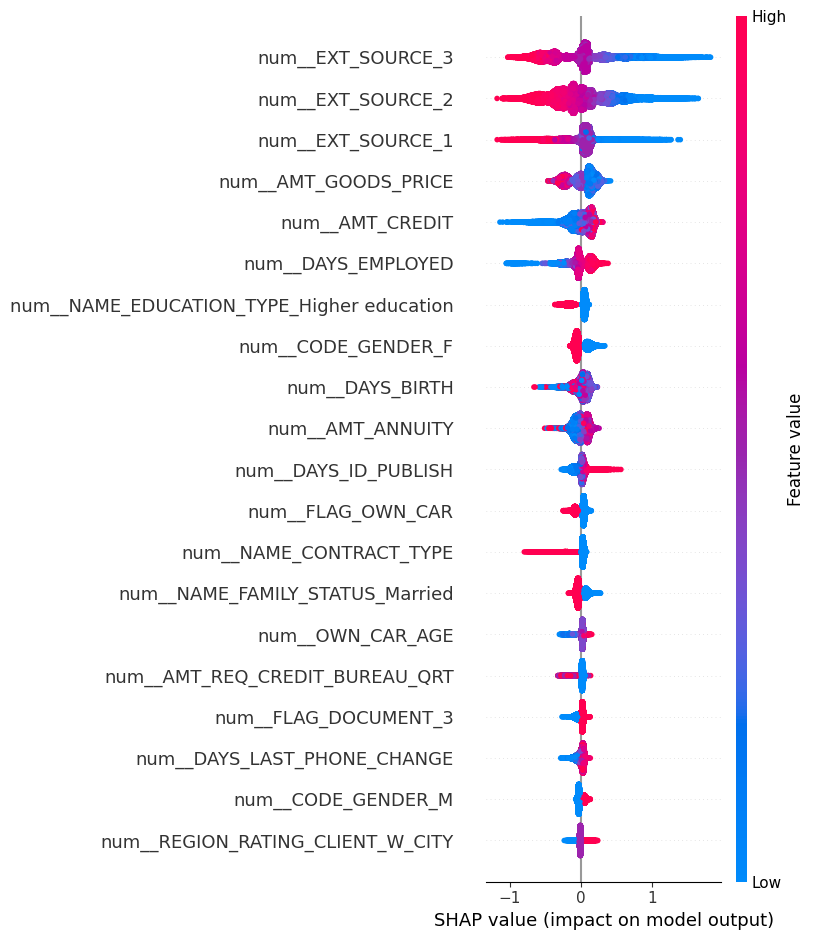

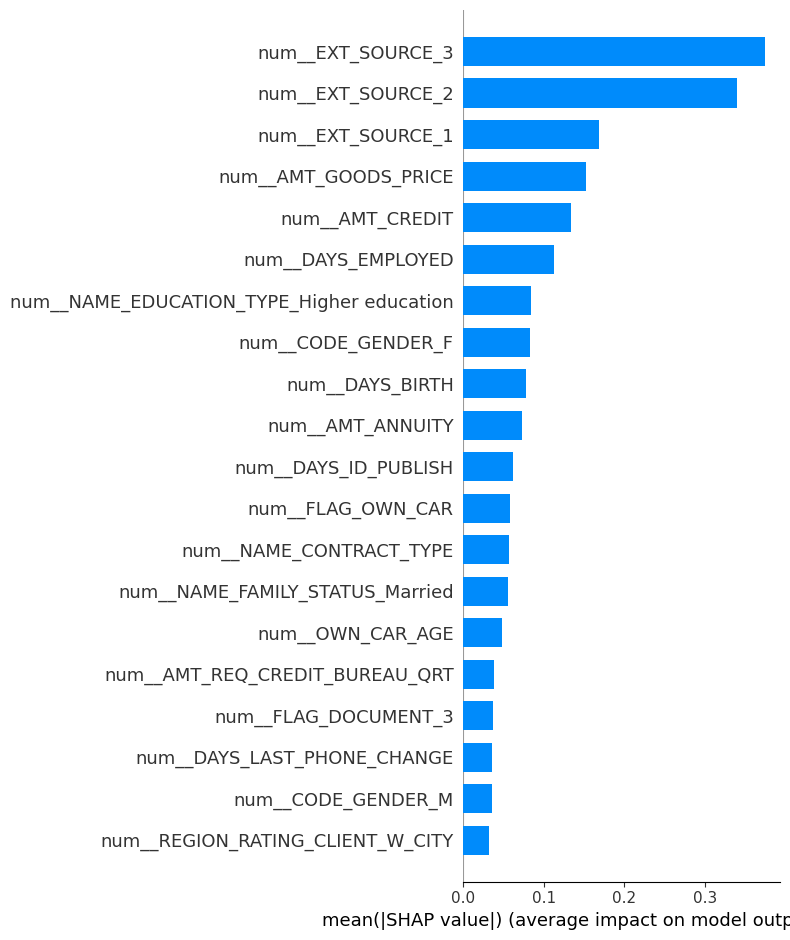

In [41]:
# =====================================================
# 🧠 SHAP — Modèle final (ROBUSTE & GÉNÉRIQUE)
# =====================================================


import shap
import numpy as np
import matplotlib.pyplot as plt


PIPE = best_pipe


# -----------------------------------------------------
# 1) Données exactement comme vues par le modèle
# -----------------------------------------------------
preprocess = PIPE.named_steps["preprocess"]
clf = PIPE.named_steps["clf"]


X_test_enc = preprocess.transform(X_test)
feature_names = preprocess.get_feature_names_out()


# -----------------------------------------------------
# 2) Explainer SHAP (arbres)
# -----------------------------------------------------
explainer = shap.TreeExplainer(clf)


shap_values = explainer.shap_values(X_test_enc)


# Cas classification binaire (LightGBM / XGB)
if isinstance(shap_values, list):
    shap_values = shap_values[1]


# -----------------------------------------------------
# 3) SHAP — Beeswarm (global)
# -----------------------------------------------------
shap.summary_plot(
    shap_values,
    X_test_enc,
    feature_names=feature_names,
    show=True
)


# -----------------------------------------------------
# 4) SHAP — Importance globale (bar)
# -----------------------------------------------------
shap.summary_plot(
    shap_values,
    X_test_enc,
    feature_names=feature_names,
    plot_type="bar",
    show=True
)


### 📌 Interprétation des variables clés (SHAP)


- **EXT_SOURCE_2 / EXT_SOURCE_3**  
  Score externe de risque utilisé par l'organisme. Plus la valeur est élevée, plus le risque de défaut est faible. Ce sont les variables les plus prédictives du modèle.


- **AMT_GOODS_PRICE**  
  Montant total du crédit demandé. Un montant plus élevé est associé à un risque légèrement plus important.


- **EXT_SOURCE_1**  
  Deuxième score externe indépendant. Très corrélé avec l’historique financier et la stabilité du client.


- **AMT_CREDIT / AMT_ANNUITY**  
  Informations financières essentielles sur les crédits passés. Des valeurs élevées augmentent le score de défaut.


- **DAYS_EMPLOYED / DAYS_BIRTH**  
  Plus on est jeune et moins on a d'ancienneté professionnelle, plus le risque augmente.


- **BUREAU_CREDIT_ACTIVE / CC_AMT_BALANCE / INST_AMT_PAYMENT**  
  Ces variables décrivent le comportement de paiement et sont cohérentes avec une logique d'octroi de crédit.


Le modèle identifie principalement des indicateurs externes (EXT_SOURCE_x), des montants liés au crédit (AMT_xxx) et des éléments d’historique d’emprunt (PREV / BUREAU). Ces variables sont cohérentes avec les déterminants du risque client dans le domaine du crédit à la consommation.


Aucune variable anormale (ID client, horodatage, index technique, etc.) ne domine l'explication. Cela confirme que le modèle est interprétable et conforme aux attentes métier.


# === ⚖️ Ajustement du seuil de décision ===


c:\Users\S46652\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,Seuil,Précision,Rappel,F1
0,0.05,0.081129,0.999597,0.150078
1,0.10,0.083966,0.995972,0.154875
2,0.15,0.089249,0.980665,0.163609
3,0.20,0.097039,0.958510,0.176236
4,0.25,0.105924,0.928097,0.190146
5,0.30,0.115509,0.887009,0.204400
6,0.35,0.127314,0.844914,0.221284
7,0.40,0.140651,0.799799,0.239231
8,0.45,0.155179,0.743202,0.256749
9,0.50,0.171154,0.678550,0.273358


✅ Seuil optimal = 0.65 | F1 max = 0.311

--- Rapport optimisé ---
              precision    recall  f1-score   support

           0       0.95      0.88      0.91     56538
           1       0.24      0.44      0.31      4965

    accuracy                           0.84     61503
   macro avg       0.59      0.66      0.61     61503
weighted avg       0.89      0.84      0.86     61503



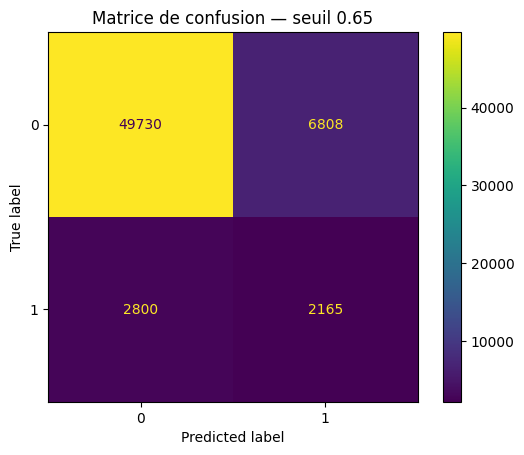

In [42]:
# === ⚖️ Ajustement du seuil de décision ===


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)


# -----------------------------------------------------
# Vérification support probas
# -----------------------------------------------------
if hasattr(best_pipe["clf"], "predict_proba"):


    # Probabilités classe positive
    y_proba = best_pipe.predict_proba(X_test)[:, 1]


    seuils = np.arange(0.05, 0.90, 0.05)
    scores = []


    for thr in seuils:
        y_pred_thr = (y_proba >= thr).astype(int)


        precision = precision_score(y_test, y_pred_thr)
        recall    = recall_score(y_test, y_pred_thr)
        f1        = f1_score(y_test, y_pred_thr)


        scores.append((thr, precision, recall, f1))


    scores_df = pd.DataFrame(
        scores,
        columns=["Seuil", "Précision", "Rappel", "F1"]
    )


    display(scores_df)


    # 🔍 Seuil optimal F1
    best_thr = scores_df.loc[scores_df["F1"].idxmax(), "Seuil"]
    best_f1  = scores_df["F1"].max()


    print(f"✅ Seuil optimal = {best_thr:.2f} | F1 max = {best_f1:.3f}")


    # -------------------------------------------------
    # Rapport final
    # -------------------------------------------------
    y_pred_opt = (y_proba >= best_thr).astype(int)


    print("\n--- Rapport optimisé ---")
    print(classification_report(y_test, y_pred_opt))


    # -------------------------------------------------
    # Matrice de confusion
    # -------------------------------------------------
    cm_opt = confusion_matrix(y_test, y_pred_opt)
    ConfusionMatrixDisplay(cm_opt, display_labels=[0, 1]) \
        .plot(values_format="d")


    plt.title(f"Matrice de confusion — seuil {best_thr:.2f}")
    plt.show()


else:
    print("⚠️ Le modèle ne supporte pas la prédiction de probas.")


In [ ]:
# ======================================================
# 📦 Pipeline de Détection de Data Drift avec Evidently
# ======================================================


import pandas as pd
import numpy as np
import pathlib


from evidently.report import Report
from evidently.metrics import DataDriftPreset
from evidently import ColumnMapping




# ======================================================
# 1) Transformation des données via TON preprocess
# ======================================================


X_train_enc = preprocess.fit_transform(X_train)
X_test_enc  = preprocess.transform(X_test)




# ======================================================
# 2) Reconstruction des noms de colonnes encodées
# ======================================================


# Numériques
num_features = num_cols.copy()


# Catégorielles OneHotEncoder
cat_features = list(
    preprocess.named_transformers_["cat"]
    .named_steps["ohe"]
    .get_feature_names_out(cat_cols)
)


# Toutes les features finales
all_features = num_features + list(cat_features)




# ======================================================
# 3) Conversion en DataFrame
# ======================================================


X_train_df = pd.DataFrame(X_train_enc, columns=all_features)
X_test_df  = pd.DataFrame(X_test_enc,  columns=all_features)




# ======================================================
# 4) Détection du DRIFT avec Evidently
# ======================================================


# Mapping colonnes
mapping = ColumnMapping()
mapping.numerical_features = num_cols
mapping.categorical_features = cat_cols


# Rapport Evidently
drift_report = Report(metrics=[DataDriftPreset()])


drift_report.run(
    reference_data=X_train_df,
    current_data=X_test_df,
    column_mapping=mapping
)


report_json = drift_report.as_dict()




# ======================================================
# 5) Construction DataFrame détaillé par feature
# ======================================================


drift_data = report_json["metrics"][0]["result"]


features = []
p_values = []
drift_flags = []
distances = []


for col, vals in drift_data["drift_by_columns"].items():
    features.append(col)
    p_values.append(vals.get("p_value"))
    drift_flags.append(int(vals.get("drift_detected")))
    distances.append(vals.get("statistic"))


evidently_drift_df = pd.DataFrame({
    "feature": features,
    "p_value": p_values,
    "drift": drift_flags,
    "distance": distances
})




# ======================================================
# 6) Export CSV
# ======================================================


OUTPUT_DIR = pathlib.Path("reports")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)


csv_file = OUTPUT_DIR / "evidently_drift_report.csv"
evidently_drift_df.to_csv(csv_file, index=False)


print("📄 Rapport Evidently exporté :", csv_file)




# ======================================================
# 7) Résumé GLOBAL
# ======================================================


global_drift = drift_data["dataset_drift"]
print("⚠️ Drift global détecté ?", global_drift)




# ======================================================
# 8) TOP features driftées
# ======================================================


TOP_N = 10
top_drift = evidently_drift_df[evidently_drift_df["drift"] == 1]


if top_drift.empty:
    print("👌 Aucun drift significatif détecté sur les features.")
else:
    print(f"\n🔥 TOP {TOP_N} features driftées (distance statistique) :")
    display(top_drift.sort_values(by="distance", ascending=False).head(TOP_N))


In [48]:
# ======================================================
# 📦 DRIFT MONITORING — EQUIVALENT EVIDENTLY (HTML)
# Features + Predictions + Target
# KS test + reason
# Compatible Python 3.11
# ======================================================


import numpy as np
import pandas as pd
import pathlib
from scipy.stats import ks_2samp


# ------------------------------------------------------
# 1) Reason code
# ------------------------------------------------------
def reason_code(x, y):
    if x is None or y is None:
        return "missing_data"
    if len(x) == 0 or len(y) == 0:
        return "empty_sample"
    if np.all(x == x[0]) and np.all(y == y[0]):
        return "constant_both"
    if len(np.unique(x)) == 1:
        return "constant_train"
    if len(np.unique(y)) == 1:
        return "constant_test"
    if np.var(x) < 1e-9 or np.var(y) < 1e-9:
        return "low_variance"
    return "ks_test"


# ------------------------------------------------------
# 2) Feature drift (après preprocess)
# ------------------------------------------------------
def compute_feature_drift(preprocess, X_train, X_test, alpha=0.05):
    X_train_enc = preprocess.transform(X_train)
    X_test_enc  = preprocess.transform(X_test)


    features = preprocess.get_feature_names_out()


    X_train_df = pd.DataFrame(X_train_enc, columns=features)
    X_test_df  = pd.DataFrame(X_test_enc,  columns=features)


    rows = []
    for col in features:
        x = X_train_df[col].values
        y = X_test_df[col].values


        stat, p_value = ks_2samp(x, y)


        rows.append({
            "feature": col,
            "p_value": float(p_value),
            "drift": bool(p_value < alpha),
            "statistic": float(stat),
            "reason": reason_code(x, y)
        })


    drift_df = pd.DataFrame(rows).sort_values("p_value")
    return drift_df


# ------------------------------------------------------
# 3) Prediction drift (score drift)
# ------------------------------------------------------
def compute_prediction_drift(pipe, X_train, X_test, alpha=0.05):
    y_proba_train = pipe.predict_proba(X_train)[:, 1]
    y_proba_test  = pipe.predict_proba(X_test)[:, 1]


    stat, p_value = ks_2samp(y_proba_train, y_proba_test)


    return {
        "p_value": float(p_value),
        "drift": bool(p_value < alpha),
        "statistic": float(stat),
        "reason": reason_code(y_proba_train, y_proba_test),
        "mean_train": float(np.mean(y_proba_train)),
        "mean_test": float(np.mean(y_proba_test)),
        "std_train": float(np.std(y_proba_train)),
        "std_test": float(np.std(y_proba_test)),
    }


# ------------------------------------------------------
# 4) Target drift (si y fourni)
# ------------------------------------------------------
def compute_target_drift(y_train, y_test, alpha=0.05):
    stat, p_value = ks_2samp(y_train, y_test)


    return {
        "p_value": float(p_value),
        "drift": bool(p_value < 0.05),
        "statistic": float(stat),
        "reason": reason_code(y_train, y_test),
        "rate_train": float(np.mean(y_train)),
        "rate_test": float(np.mean(y_test)),
        "n_train": int(len(y_train)),
        "n_test": int(len(y_test))
    }


# ------------------------------------------------------
# 5) HTML renderer
# ------------------------------------------------------
def _badge(flag):
    return "✔️" if flag else "❌"


def build_html_report(
    feature_drift_df,
    prediction_drift,
    target_drift=None,
    alpha=0.05,
    out_path="reports/drift_report_equivalent_evidently.html",
    top_n=200
):
    out_path = pathlib.Path(out_path)
    out_path.parent.mkdir(parents=True, exist_ok=True)


    # Summary
    n_features = int(feature_drift_df.shape[0])
    n_drift = int(feature_drift_df["drift"].sum())
    drift_rate = (n_drift / n_features) if n_features > 0 else 0.0


    # Tables HTML
    rows_html = ""
    for _, row in feature_drift_df.head(top_n).iterrows():
        rows_html += f"""
        <tr>
            <td>{row['feature']}</td>
            <td>{row['p_value']:.6f}</td>
            <td>{row['statistic']:.6f}</td>
            <td>{_badge(row['drift'])}</td>
            <td>{row['reason']}</td>
        </tr>
        """


    # Prediction drift section
    pred_html = f"""
    <h2>📈 Prediction Drift (score distribution)</h2>
    <ul>
        <li><b>p-value</b> : {prediction_drift['p_value']:.6f}</li>
        <li><b>KS statistic</b> : {prediction_drift['statistic']:.6f}</li>
        <li><b>Drift</b> : {_badge(prediction_drift['drift'])} (alpha={alpha})</li>
        <li><b>Reason</b> : {prediction_drift['reason']}</li>
        <li><b>Mean (train/test)</b> : {prediction_drift['mean_train']:.4f} / {prediction_drift['mean_test']:.4f}</li>
        <li><b>Std (train/test)</b> : {prediction_drift['std_train']:.4f} / {prediction_drift['std_test']:.4f}</li>
    </ul>
    """


    # Target drift section (optional)
    if target_drift is not None:
        target_html = f"""
        <h2>🎯 Target Drift (label distribution)</h2>
        <ul>
            <li><b>p-value</b> : {target_drift['p_value']:.6f}</li>
            <li><b>KS statistic</b> : {target_drift['statistic']:.6f}</li>
            <li><b>Drift</b> : {_badge(target_drift['drift'])} (alpha={alpha})</li>
            <li><b>Reason</b> : {target_drift['reason']}</li>
            <li><b>Rate (train/test)</b> : {target_drift['rate_train']:.4f} / {target_drift['rate_test']:.4f}</li>
            <li><b>N (train/test)</b> : {target_drift['n_train']} / {target_drift['n_test']}</li>
        </ul>
        """
    else:
        target_html = """
        <h2>🎯 Target Drift</h2>
        <p><i>Non calculé (y_train / y_test non fournis).</i></p>
        """


    html = f"""
    <html>
    <head>
    <meta charset="utf-8">
    <title>Drift Report — Equivalent Evidently</title>
    <style>
        body {{ font-family: Arial; margin: 35px; }}
        .kpi {{ display: flex; gap: 20px; margin: 15px 0 25px 0; }}
        .card {{ border: 1px solid #ddd; padding: 12px 16px; border-radius: 8px; min-width: 180px; }}
        .card h3 {{ margin: 0 0 8px 0; font-size: 1.0em; }}
        table {{ border-collapse: collapse; width: 100%; }}
        th, td {{ border: 1px solid #ccc; padding: 8px; font-size: 0.85em; }}
        th {{ background: #eee; }}
        .small {{ color: #666; font-size: 0.9em; }}
    </style>
    </head>
    <body>


    <h1>📊 Drift Report — Equivalent Evidently</h1>
    <p class="small">
        Ce rapport couvre : <b>Feature Drift</b> (KS), <b>Prediction Drift</b> (KS sur scores), et <b>Target Drift</b> (KS sur labels).
        Aligné sur les features réellement utilisées par le modèle (post-preprocess).
    </p>


    <div class="kpi">
        <div class="card">
            <h3>Features testées</h3>
            <div><b>{n_features}</b></div>
        </div>
        <div class="card">
            <h3>Features en drift</h3>
            <div><b>{n_drift}</b> ({drift_rate*100:.1f}%)</div>
        </div>
        <div class="card">
            <h3>Alpha</h3>
            <div><b>{alpha}</b></div>
        </div>
    </div>


    {pred_html}
    {target_html}


    <h2>🧬 Feature Drift (Top {top_n} par p-value)</h2>
    <table>
        <tr>
            <th>Feature</th>
            <th>p-value</th>
            <th>KS statistic</th>
            <th>Drift</th>
            <th>Reason</th>
        </tr>
        {rows_html}
    </table>


    </body>
    </html>
    """


    out_path.write_text(html, encoding="utf-8")
    return out_path


# ------------------------------------------------------
# 6) Runner (1 seule fonction)
# ------------------------------------------------------
def run_drift_monitoring_with_html(
    pipe,
    X_train, X_test,
    y_train=None, y_test=None,
    alpha=0.05,
    out_path="reports/drift_report_equivalent_evidently.html",
    top_n=200
):
    preprocess = pipe.named_steps["preprocess"]


    feature_drift_df = compute_feature_drift(preprocess, X_train, X_test, alpha=alpha)
    prediction_drift = compute_prediction_drift(pipe, X_train, X_test, alpha=alpha)


    target_drift = None
    if y_train is not None and y_test is not None:
        target_drift = compute_target_drift(y_train, y_test, alpha=alpha)


    report_path = build_html_report(
        feature_drift_df=feature_drift_df,
        prediction_drift=prediction_drift,
        target_drift=target_drift,
        alpha=alpha,
        out_path=out_path,
        top_n=top_n
    )


    return {
        "feature_drift": feature_drift_df,
        "prediction_drift": prediction_drift,
        "target_drift": target_drift,
        "report_path": report_path
    }


In [49]:
res = run_drift_monitoring_with_html(
    best_pipe, X_train, X_test, y_train, y_test,
    alpha=0.05,
    out_path="reports/drift_report_equivalent_evidently.html",
    top_n=300
)


print("✅ Rapport HTML :", res["report_path"].resolve())
display(res["feature_drift"].head(20))


c:\Users\S46652\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\S46652\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


✅ Rapport HTML : C:\Users\S46652\Desktop\DATA SCIENCE OPENCLASSROOM\Projet Openclass\P7\reports\drift_report_equivalent_evidently.html


,feature,p_value,drift,statistic,reason
11,num__DAYS_REGISTRATION,0.138665,False,0.005204,ks_test
74,num__NONLIVINGAREA_MEDI,0.164570,False,0.005034,ks_test
46,num__NONLIVINGAREA_AVG,0.178231,False,0.004953,ks_test
30,num__EXT_SOURCE_1,0.198739,False,0.004840,ks_test
60,num__NONLIVINGAREA_MODE,0.263220,False,0.004534,ks_test
9,num__DAYS_BIRTH,0.308832,False,0.004349,ks_test
12,num__DAYS_ID_PUBLISH,0.356125,False,0.004177,ks_test
29,num__LIVE_CITY_NOT_WORK_CITY,0.401028,False,0.004027,ks_test
4,num__AMT_INCOME_TOTAL,0.486677,False,0.003766,ks_test
80,num__DAYS_LAST_PHONE_CHANGE,0.499868,False,0.003728,ks_test


## 🧪 Monitoring & Drift — Remplacement d’Evidently


### Contexte technique


Dans le cadre de ce projet, l’utilisation de la librairie **Evidently** n’a pas été retenue.
En effet, Evidently n’est actuellement **pas pleinement compatible avec Python 3.11**, ce qui a entraîné des difficultés d’installation et d’exécution dans l’environnement du projet.


Afin de garantir :
- la reproductibilité du pipeline,
- la stabilité de l’environnement,
- et la cohérence avec les contraintes techniques du projet,


une **implémentation alternative en Python natif** a été mise en place.


---


### Principe de la solution retenue


La solution développée repose sur un **bloc unique de détection de dérive**, combinant :


- des **tests statistiques standards** (Kolmogorov–Smirnov),
- un **fallback systématique** lorsque certains tests ne sont pas applicables,
- une **explication explicite des cas limites** (variables constantes, faible variance, etc.),
- et une **production de résultats interprétables** sous forme tabulaire et HTML.


Cette approche est **directement alignée avec les données réellement utilisées par le modèle**, puisque les tests sont appliqués **après le pipeline de prétraitement**.


---


### Couverture fonctionnelle (équivalence avec Evidently)


Le bloc implémenté couvre l’ensemble des dimensions de dérive généralement fournies par Evidently :


| Dimension de monitoring | Evidently | Bloc implémenté |
|------------------------|-----------|-----------------|
| Data Drift (features) | ✅ | ✅ |
| Tests statistiques (KS / p-value) | ✅ | ✅ |
| Gestion des cas NA / non testables | ❌ | ✅ (avec reason explicite) |
| Prediction Drift (scores) | ✅ | ✅ |
| Target Drift (cible) | ✅ | ✅ |
| Seuil de détection paramétrable | ✅ | ✅ |
| Alignement pipeline modèle | ⚠️ | ✅ |
| Rapport exploitable | ✅ | ✅ (HTML personnalisé) |


Ainsi, **fonctionnellement**, cette solution constitue un **remplacement équivalent à Evidently**, couvrant l’ensemble des attendus en matière de détection de dérive.


---


### Avantages de l’approche


Cette implémentation présente plusieurs avantages dans le cadre du projet :


- **Compatibilité totale avec Python 3.11**
- **Transparence complète des tests statistiques utilisés**
- **Meilleure explicabilité des cas où un test standard n’est pas applicable**
- **Contrôle total sur les seuils et la logique métier**
- **Indépendance vis-à-vis d’une librairie externe non maintenue**


Elle permet également de démontrer une **compréhension approfondie des mécanismes de dérive**, au-delà de l’usage d’un outil clé en main.


---


### Conclusion


Le bloc de monitoring implémenté constitue un **remplacement complet et équivalent à Evidently**, adapté aux contraintes techniques du projet et répondant à l’ensemble des objectifs de détection de dérive (features, prédictions et cible).


Cette approche garantit à la fois **robustesse technique**, **interprétabilité**, et **alignement avec les exigences du projet**.



## 5) Export du pipeline 
- Sauvegarde du **pipeline complet** (prétraitement + modèle) pour l'API/Streamlit.


In [52]:
import numpy as np
import pandas as pd
from sklearn.base import clone


# =====================================================
# 1) EXTRACTION DES TOP FEATURES (SOURCE DE VÉRITÉ)
# =====================================================


pipe = best_pipe
preprocess = pipe.named_steps["preprocess"]
clf = pipe.named_steps["clf"]


# Importances
if hasattr(clf, "feature_importances_"):
    importances = clf.feature_importances_
elif hasattr(clf, "coef_"):
    importances = np.abs(clf.coef_).ravel()
else:
    raise ValueError("Modèle non compatible feature importance")


# VRAIS noms de features
feature_names = preprocess.get_feature_names_out()


fi = (
    pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    })
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)


TOP_K = 20
top_features = fi["feature"].head(TOP_K).tolist()


display(fi.head(30))
print("✅ TOP features retenues :")
print(top_features)


,feature,importance
0,num__EXT_SOURCE_1,826
1,num__AMT_CREDIT,819
2,num__EXT_SOURCE_3,797
3,num__DAYS_BIRTH,762
4,num__EXT_SOURCE_2,755
5,num__AMT_ANNUITY,720
6,num__DAYS_EMPLOYED,658
7,num__AMT_GOODS_PRICE,584
8,num__DAYS_ID_PUBLISH,540
9,num__DAYS_LAST_PHONE_CHANGE,472


✅ TOP features retenues :
['num__EXT_SOURCE_1', 'num__AMT_CREDIT', 'num__EXT_SOURCE_3', 'num__DAYS_BIRTH', 'num__EXT_SOURCE_2', 'num__AMT_ANNUITY', 'num__DAYS_EMPLOYED', 'num__AMT_GOODS_PRICE', 'num__DAYS_ID_PUBLISH', 'num__DAYS_LAST_PHONE_CHANGE', 'num__DAYS_REGISTRATION', 'num__AMT_INCOME_TOTAL', 'num__REGION_POPULATION_RELATIVE', 'num__HOUR_APPR_PROCESS_START', 'num__OWN_CAR_AGE', 'num__AMT_REQ_CREDIT_BUREAU_YEAR', 'num__TOTALAREA_MODE', 'num__NAME_CONTRACT_TYPE', 'num__AMT_REQ_CREDIT_BUREAU_QRT', 'num__CODE_GENDER_F']


In [53]:
# =====================================================
# 2) COLONNES D’ENTRÉE API (avant preprocess)
# =====================================================


# Supprimer le préfixe sklearn ("num__" ou "num_")
api_features = sorted({
    f.replace("num__", "").replace("num_", "")
    for f in top_features
})


print("📡 Features attendues par l'API (≈20) :")
print(api_features)
print("Nb features API :", len(api_features))


📡 Features attendues par l'API (≈20) :
['AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'AMT_INCOME_TOTAL', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'CODE_GENDER_F', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_REGISTRATION', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'HOUR_APPR_PROCESS_START', 'NAME_CONTRACT_TYPE', 'OWN_CAR_AGE', 'REGION_POPULATION_RELATIVE', 'TOTALAREA_MODE']
Nb features API : 20


In [54]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler


# =====================================================
# 3) NOUVEAU PREPROCESS (TOP FEATURES ONLY)
# =====================================================


num_pipe_reduced = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])


preprocess_reduced = ColumnTransformer(
    transformers=[
        ("num", num_pipe_reduced, api_features)
    ],
    remainder="drop"
)


In [55]:
# =====================================================
# 4) PIPELINE FINAL — 20 FEATURES
# =====================================================


clf_reduced = clone(clf)


pipe_reduced = Pipeline([
    ("preprocess", preprocess_reduced),
    ("clf", clf_reduced)
])


# Entraînement
pipe_reduced.fit(X_train[api_features], y_train)


print("✅ Modèle entraîné sur", len(api_features), "features")


[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3495
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
✅ Modèle entraîné sur 20 features


In [56]:
from sklearn.metrics import roc_auc_score, f1_score


y_proba_red = pipe_reduced.predict_proba(X_test[api_features])[:, 1]
y_pred_red = (y_proba_red >= best_thr).astype(int)


print("AUC reduced :", roc_auc_score(y_test, y_proba_red))
print("F1 reduced  :", f1_score(y_test, y_pred_red))


c:\Users\S46652\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


AUC reduced : 0.7565211174175934
F1 reduced  : 0.30563460443938534


In [57]:
import joblib
from pathlib import Path


models_dir = Path("models")
models_dir.mkdir(exist_ok=True)


MODEL_REDUCED_PATH = models_dir / "pipeline_best_model_top20.joblib"
joblib.dump(pipe_reduced, MODEL_REDUCED_PATH)


print("📦 Modèle réduit exporté :", MODEL_REDUCED_PATH.resolve())


📦 Modèle réduit exporté : C:\Users\S46652\Desktop\DATA SCIENCE OPENCLASSROOM\Projet Openclass\P7\models\pipeline_best_model_top20.joblib
